<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #7: Clasificación y Agrupación
`Fecha de entrega: Octubre 24, 2020. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [1]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [2]:
# Cargar datos
path = 'archivos/reviews_vidjew_es.csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


# Parte 1: Clasificación

### `[6 pts]` Punto 1: Dividir el conjunto de datos en entrenamiento y prueba

In [3]:
data.product_category.value_counts(normalize=True)

jewelry        0.502
video_games    0.498
Name: product_category, dtype: float64

In [4]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

print(f"El cojunto de datos de entrenamiento tiene {train.shape[0]} registros")
print(f"El cojunto de datos de prueba tiene {test.shape[0]} registros")

El cojunto de datos de entrenamiento tiene 800 registros
El cojunto de datos de prueba tiene 200 registros


###  `[6 pts]` Punto 2: Hacer pre-procesamiento del texto

In [5]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [10]:
data.stars = data.stars.apply(lambda val: str(val))

In [11]:
X_train = tfidf_vect.fit_transform(train.review_body.values)
y_train = train.stars.values

X_test = tfidf_vect.transform(test.review_body.values)
y_test = test.stars.values

###  `[6 pts]` Punto 3: Entrenar el modelo
Puedes escoger el que quieras: Regresión Logística, Naive-Bayes, SVM, u otro.

In [12]:
# Inicializamos los clasificadores
logreg = LogisticRegression(class_weight="balanced")

# Entrenamos los modelos
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

###  `[6 pts]` Punto 4: Métricas de evaluación
Exactitud, precisión y sensibilidad

In [13]:
# Hacemos las predicciones para los datos de prueba (test)
y_pred_logreg = logreg.predict(X_test)

print(f"Exactitud: {accuracy_score(y_test, y_pred_logreg):.2f}")

metricas = [precision_score, recall_score, f1_score]

for metrica in metricas:
    print(f"{metrica.__name__}: {metrica(y_test, y_pred_logreg, pos_label='jewelry'):.2f}")

Exactitud: 0.35


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

###  `[BONUS: 3 pts]` Matriz de confusión

Text(0.5, 1.0, 'Regresión Logística')

<Figure size 1080x1080 with 0 Axes>

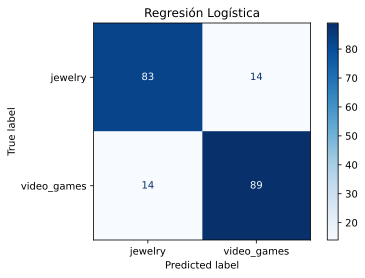

In [9]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize=(15,15))

plot_confusion_matrix(logreg, X_test, y_test, cmap = 'Blues')
plt.title("Regresión Logística")

###  `[BONUS: 1 pts]` Términos más importantes de cada categoría

In [17]:
vocab = {value:key for key, value in tfidf_vect.vocabulary_.items()}

In [18]:
[(vocab[e[0]],round(e[1],2)) for e in zip(logreg.coef_[0].argsort(),sorted(logreg.coef_[0]))][-10:]

[('llegó', 1.01),
 ('producto', 1.06),
 ('fatal', 1.09),
 ('mala', 1.11),
 ('nunca', 1.15),
 ('devuelto', 1.16),
 ('roto', 1.19),
 ('llega', 1.21),
 ('recibido', 1.3),
 ('llegado', 1.41)]

In [19]:
[(vocab[e[0]],round(e[1],2)) for e in zip(logreg.coef_[0].argsort(),sorted(logreg.coef_[0]))][:10]

[('bien', -1.35),
 ('perfecto', -1.16),
 ('precio', -1.11),
 ('bonito', -1.06),
 ('buen', -1.03),
 ('aunque', -0.86),
 ('juego', -0.83),
 ('bonita', -0.77),
 ('buena', -0.76),
 ('tamaño', -0.71)]

# Parte 2: Agrupación

In [37]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect2 = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect2.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect2.get_feature_names())

In [38]:
k = 2
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)
nbrs = NearestNeighbors(n_neighbors=3, metric="euclidean").fit(tfidf_matrix.values)

In [39]:
data['cluster'] = model.labels_
clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)
 
centroides = model.cluster_centers_
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect2.get_feature_names()
 
print(f"CLUSTERS:\n")

for i in range(k):
    print(f"Cluster #{i}")
    print(f"{clust_cnt[i]} textos ({clust_cnt_pct[i]:.2%} de los datos)")
    print(f"TERMINOS: ", end=" ")
    for idx in order_centroids[i, :15]:
        print(f"{terms[idx]}", end=" ")
    print("\n")
    print(f"Textos Representativos")
    for texto in data.iloc[nbrs.kneighbors([centroides[i]])[1][0]]['review_body'].values:
        print(f"* {texto}")
    print("\n")

CLUSTERS:

Cluster #0
866 textos (86.60% de los datos)
TERMINOS:  bien juego producto perfecto bonito si llegado buen mas foto precio regalo tiempo llegó bonitos 

Textos Representativos
* Bonito fue para un regalo y bien
* El producto en buen estado. Perfecto.
* Acerté con el regalo, lo recomiendo queda muy chulo. El tamaño del colgante está bien justo como sale en la foto. Viene con una cadena que está bien para el precio.


Cluster #1
134 textos (13.40% de los datos)
TERMINOS:  calidad buena precio bien regalo mala bastante buen demasiado gustado bonito cadena relación baja compra 

Textos Representativos
* Calidad precio buena
* Calidad precio muy buena
* Calidad precio buena




In [41]:
clusters = {0:'video_games',
            1:'jewelry'}

data['cluster_name'] = data['cluster'].apply(lambda val: clusters[val])
data['texto_peq'] = data['review_body'].apply(lambda texto: texto[:100])
data

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,cluster,cluster_name,texto_peq
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry,1,jewelry,"Buen. Buena calidad, y buena presentación."
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games,0,video_games,"Un producto a perfecto, para salir de casa con..."
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games,0,video_games,No funciona con Nintendo Switch. No hay forma ...
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games,0,video_games,"Recomendado, los utilizo para pc y no me dan n..."
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games,0,video_games,El cable funciona bien podria ser un poco mas ...
...,...,...,...,...,...,...,...,...,...,...,...
995,es_0427672,product_es_0899883,reviewer_es_0474735,2,En la foto parece que la cadena sea más gruesa...,Cadena muy fina,es,jewelry,0,video_games,En la foto parece que la cadena sea más gruesa...
996,es_0059540,product_es_0702564,reviewer_es_0754753,3,"Bien por su precio, la cadena demasiado fina.",E,es,jewelry,1,jewelry,"Bien por su precio, la cadena demasiado fina."
997,es_0303349,product_es_0678671,reviewer_es_0172313,5,Muy bien!! Ahora tengo organizados los pendien...,Bonito,es,jewelry,0,video_games,Muy bien!! Ahora tengo organizados los pendien...
998,es_0659961,product_es_0294943,reviewer_es_0554554,4,"Las tapas para los joystics no están nada mal,...",No está mal pero sólo he probado las fundas.,es,video_games,0,video_games,"Las tapas para los joystics no están nada mal,..."


In [42]:
print(f"Naive Bayes: {accuracy_score(data.product_category.values, data.cluster_name.values):>15.2f}")

Naive Bayes:            0.57


In [43]:
for metrica in metricas:
    print(metrica.__name__)
    print(f"Naive Bayes: {metrica(data.product_category.values, data.cluster_name.values, pos_label='jewelry'):>15.2f}")
    print()

precision_score
Naive Bayes:            0.75

recall_score
Naive Bayes:            0.20

f1_score
Naive Bayes:            0.32



In [29]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

#la columna en la que haremos el análisis de clusterización será la de "review_body"
tfidf_vect_2 = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect_2.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect_2.get_feature_names())
tfidf_matrix

,abajo,abalorio,abalorios,abaratar,abate,abierta,abierto,ablar,aboné,abre,...,éste,éxito,ópticas,última,últimas,últimos,única,únicamente,único,útil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
k = 7
model =KMeans(n_clusters=k)
model.fit(tfidf_matrix)
data['cluster'] = model.labels_
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,cluster
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry,3
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games,0
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games,6
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games,1
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games,1


In [36]:
for i in range(k):
    print(f"{i}")
    
    print(f"{i:.2%}")

0
0.00%
1
100.00%
2
200.00%
3
300.00%
4
400.00%
5
500.00%
6
600.00%


In [31]:
nbrs= NearestNeighbors(n_neighbors=3, metric = 'euclidean').fit(tfidf_matrix.values)
order_centroids=model.cluster_centers_.argsort()[:, ::-1]

#por buena práctica hacemos la siguiente linea
clust_cnt=data ['cluster'].value_counts()
clust_cnt_pct=data['cluster'].value_counts(normalize=True)

centroides = model.cluster_centers_
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect_2.get_feature_names()

print(f"CLUSTERS:\n")
for i in range (k):
    print(f"Cluster #{i} ")
    print (f"{clust_cnt[i]} textos ({clust_cnt[i]:.2%} de los datos)")
    print(f"TERMINOS: "  , end=" ")
    for idx in order_centroids[i, :2]:
        print (f"{terms[idx]}", end= " ")
    print ("\n\n")
    print (f"Términos representativos")
    for texto in data.iloc[nbrs.kneighbors([centroides [i]])[1][0]]['review_body'].values:
        print(f"*{texto}")
    print ("\n")

CLUSTERS:

Cluster #0 
60 textos (6000.00% de los datos)
TERMINOS:  perfecto tiempo 


Términos representativos
*Perfecto y en tiempo
*Llegó a tiempo y en perfecto estado
*Todo en perfecto estado


Cluster #1 
122 textos (12200.00% de los datos)
TERMINOS:  bien precio 


Términos representativos
*Está bien por su precio
*Por el precio que tiene está muy bien
*Esta bien calidad precio


Cluster #2 
34 textos (3400.00% de los datos)
TERMINOS:  pequeños grandes 


Términos representativos
*Los más grandes que hay son muy pequeños.
*Demasiado pequeños, en la foto parecían mas grandes
*Son demasiado grandes


Cluster #3 
101 textos (10100.00% de los datos)
TERMINOS:  calidad buena 


Términos representativos
*Calidad precio buena
*Calidad precio buena
*Calidad precio muy buena


Cluster #4 
79 textos (7900.00% de los datos)
TERMINOS:  juego español 


Términos representativos
*Esperaba más del juego.
*No me ha gustado el juego.
*Juego en español, envío rápido


Cluster #5 
51 textos (5100.0

###  `[6 pts]` Punto 1: Hacer pre-procesamiento del texto

In [20]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect_kmeans = TfidfVectorizer(preprocessor=pre_procesado)
tfidf_kmeans = tfidf_vect_kmeans.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf_kmeans.toarray(), columns=tfidf_vect_kmeans.get_feature_names())

###  `[6 pts]` Punto 2: Método del codo para determinar $K$

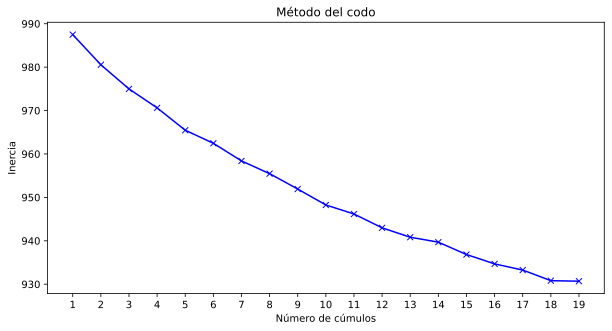

In [19]:
ks = []
kinertia = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    ks.append(k)
    kinertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10,5))
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title('Método del codo')
plt.xticks(ks)
plt.plot(ks,kinertia, 'bx-');

###  `[6 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [22]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [26]:
k = 5
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

data['cluster'] = model.labels_
clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

print(f"{color.BOLD}CLUSTERS:\n{color.END}")
centroids = model.cluster_centers_
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect_kmeans.get_feature_names()

for i in range(k):
    print(f"{color.BLUE}Cluster {i}:{color.END}")
    print(f"{color.CYAN}COUNT {color.END} {clust_cnt[i]} comments ({clust_cnt_pct[i]:.2%} of the data)")
    print(f"{color.CYAN}TERMS {color.END}", end=" ")
    for ind in order_centroids[i, :20]:
        print(f'{color.BOLD}{terms[ind]}{color.END}', end=" "),
    print(f"\n{color.CYAN}REPRESENTATIVE COMMENTS{color.END}")
    for comment in data.iloc[nbrs.kneighbors([centroids[i]])[1][0]]['review_body'].values:
        print(f"* {comment}")
    print("\n")

CLUSTERS:

Cluster 0:
COUNT  236 comments (23.60% of the data)
TERMS  mayor perla debiles tercero web oxida recomendaria condensa embarazada solucionar porfavor llevándolo wifi blanco número especificado marrón calor encontrado octubre 
REPRESENTATIVE COMMENTS
* El envío fue rápido y correcto como siempre, en este aspecto ninguna queja. En cuanto al producto no es tanto como lo publicitan, las perlas son de plástico y no tengo muy claro cuánta cantidad de plata llevan, por no ablar de las piedritas. No pesan nada y parece de los de juguete de las niñas pequeñas (los cierres son de plástico); desde luego no valen más del precio que tienen, (según ellos con el descuento que hacen), pues el precio original que pone no valen ni por asomo. No los he devuelto porque eran para regalar y no me daba tiempo a mirar otra cosa. En resumen son bonitos y dan el pego pero nada más.
* Vienen dos pares de fundas, de tamaños distintos. Las normales miden 7mm de altura, una vez colocadas sobresalen unos 

###  `[BONUS: 3 pts]` Visualización usando PCA

In [28]:
pca = PCA(n_components=2)

traces = []

for stars in [1,2,3,4,5]:
    result = pca.fit_transform(tfidf_matrix)
    result = pd.DataFrame(result)
    result.columns = ['X', 'Y']
    result['cluster'] = data.cluster.values
    result['texto'] = data.stars.values
    
    result = result[result.texto==stars]

    trace = go.Scatter(x=result['X'].values,
                       y=result['Y'].values,
                       text=result['texto'].values,
                       mode='markers',
                       marker=dict(color=result['cluster'].values),
                       name='stars') 
    traces.append(trace)

layout = go.Layout(title="PCA")

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [25]:
def pre_procesado2(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    return texto


tfidf_vect2 = TfidfVectorizer(preprocessor=pre_procesado2)
tfidf = tfidf_vect2.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect2.get_feature_names())

# Parte 3: Comparación

### `[6 pts]` Punto 1: Hacer predicción para estas dos frases de los dos modelos

In [22]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]
nuevo_trans = tfidf_vect.transform(test)
nuevo_trans_kmeans = tfidf_vect_kmeans.transform(test)

print(logreg.predict(nuevo_trans))
print(model.predict(nuevo_trans_kmeans))

['video_games' 'jewelry']
[3 4]


### `[2 pts]` Punto 2: Preguntas

- ¿A cuál modelo le fue mejor? 
- ¿Cuál modelo se demoró más en entrenar? 
- Según los resultados del $K$-Means, ¿cuál es la estructura latente de los datos?
- ¿Alguna otra observación?